In [1]:
## import general libraries
import numpy as np
import pandas as pd
import re
import json
import glob
# import nltk
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
# from gensim.models import coherencemodel
from APIs.Data_Cleaning import datacleaning, datamapping, datapreprocessing

import nltk
nltk.data.path.append("/home/fibebocai/nltk_data/")
from nltk.corpus import stopwords
import en_core_web_sm
from nltk.stem import WordNetLemmatizer

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
import ray

2022-06-27 10:53:28.012104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/lsf_10.1.0/10.1/linux3.10-glibc2.17-x86_64/lib:/home/fibebocai/virtualenvs/fibebocai_text/lib/python3.7/site-packages/pyoracleclient/instantclient
2022-06-27 10:53:28.012128: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
"""The oop based class which is responsible for all the data preprocessing needed. If you want to edit more, please find the class
in the APIs folder"""
from APIs.Data_Processing import Data_Processing
from nltk.corpus import stopwords
ticketname = "Data/Ticket Details.xlsx"
stopwords = stopwords.words("english")

"""if you find some words which is causing noise in the topic creation or which are not contributing much in the topic 
generation then add the word below"""

stopwords.extend(['from', 'subject', 're', 'edu', 'use', 'infineon', 'camstar','com', 'screenshot','yoda','lot','iptester',\
                        "mkz","mkzsapa","mkzsapaxx","site","xml", "total","camstarportal","camstarweb","team","go","gk","gl","alf",\
                        "give","zhouyang","morning","get","getquerytext","ghani","unknown","glue","generate","generation","green",\
                        "afternoon","good","evening","night","user","freeze","full","forward","hello","baby","id", "cannot","unable","add",\
                        "flex", "error message", "error","able","due","mgt","sba","allow","bin","still","workflow","hence","ok","since","critical",\
                        "urgent", "priority", "request","need", "main", "create","would","like","track","must",\
                        "prior","high","find","type","select", "job","fa","type","show", "status",\
                        "contact", "affected","area", "number","server","bth","info","sin","rc","su","mkzpa","attached","za",\
                  "integration","application"])
a = Data_Processing(ticketname, stopwords) 
[df_reviews, data_words] = a.getdata()

In [4]:
df_reviews

,Ticketid,Problem Description,Desc,raw,desc,common_words
0,INC000004851282,(1) Problem description on error*: (Including ...,(1) problem description on error*: (including ...,message evaluation variable wiptxnname clf con...,message evaluation variable wiptxnname clf con...,message evaluation variable context expression
1,INC000004851418,(1) Problem description on error*: (Including ...,(1) problem description on error*: (including ...,fajob xspav belong equipment sptv,fajob xspav belong equipment sptv,belong equipment
2,INC000004851509,(1) Problem description on error*: (Including ...,(1) problem description on error*: (including ...,trackout splitlote ndpw item quantity match qu...,trackout splitlote ndpw item quantity match qu...,item quantity match quantity
3,INC000004852100,(1) Problem description on error*: (Including ...,(1) problem description on error*: (including ...,move strip map quantity match quantity admin a...,move strip map quantity match quantity admin a...,move strip map quantity match quantity adjust ...
4,INC000004852509,(1) Problem description on error*: (Including ...,(1) problem description on error*: (including ...,,,
...,...,...,...,...,...,...
9577,INC000006004547,(1) Problem description on error* (Including s...,(1) problem description on error* (including s...,raise ticket inform problem state inprep infor...,raise ticket inform problem state inprep infor...,raise ticket inform problem state inform change
9578,INC000006004548,(1) Problem description on error* (Including s...,(1) problem description on error* (including s...,button grey,button grey,button grey
9579,INC000006004924,(1) Problem description on error* (Including s...,(1) problem description on error* (including s...,original quantity track show,original quantity track show,original quantity
9580,INC000006005058,(1) Problem description on error* (Including s...,(1) problem description on error* (including s...,allow pomblk insubcon,allow pomblk insubcon,


In [5]:
import ClusterTransformer.ClusterTransformer as ctrans
import pandas as pd

cr = ctrans.ClusterTransformer()
model_name = "albert-base-v1"

In [6]:
batch_size = 500
max_seq_length = 64
convert_to_numpy = False
normalize_embeddings = False
neighborhood_min_size = 1
cutoff_threshold = 0.83
kmeans_max_iter = 100
kmeans_random_state = 42
kmeans_no_cluster = 15
li_sentence = df_reviews['common_words']

In [7]:
ray.shutdown()
ray.init(num_cpus=16)
@ray.remote
def train(batch_size, li_sentence, model_name, max_seq_length, convert_to_numpy, normalize_embeddings, neighborhood_min_size, cutoff_threshold, kmeans_max_iter, kmeans_random_state, kmeans_no_cluster):
    embeddings = cr.model_inference(li_sentence, batch_size, model_name, max_seq_length, normalize_embeddings, convert_to_numpy)
    output_dict = cr.neighborhood_detection(li_sentence, embeddings, cutoff_threshold, neighborhood_min_size)
    output_kmeans_dict = cr.kmeans_detection(li_sentence, embeddings, kmeans_no_cluster, kmeans_max_iter, kmeans_random_state)
    neighborhood_detection_df = cr.convert_to_df(output_dict)
    kmeans_df = cr.convert_to_df(output_kmeans_dict)
    return [neighborhood_detection_df, kmeans_df, output_kmeans_dict, output_dict, embeddings]

[neighborhood_detection_df, kmeans_df, output_kmeans_dict, output_dict, embeddings] = ray.get(train.remote(batch_size, li_sentence, model_name, max_seq_length, convert_to_numpy, normalize_embeddings, neighborhood_min_size, cutoff_threshold, kmeans_max_iter, kmeans_random_state, kmeans_no_cluster))


File descriptor limit 4000 is too low for production servers and may result in connection errors. At least 8192 is recommended. --- Fix with 'ulimit -n 8192'
2022-06-27 10:54:18,991	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8265
(train pid=2151047) Some weights of the model checkpoint at albert-base-v1 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.decoder.weight', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias']
(train pid=2151047) - This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(train pid=2151047) - This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenc

(train pid=2151047) Some weights of the model checkpoint at albert-base-v1 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.decoder.weight', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias']
(train pid=2151047) - This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(train pid=2151047) - This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(train pid=2151047) Some weights of the model checkpoint at albert-base-v1 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.decoder.weight', 'predictions.dens

(train pid=2151047) huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
(train pid=2151047) To disable this warning, you can either:
(train pid=2151047) 	- Avoid using `tokenizers` before the fork if possible
(train pid=2151047) 	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DataFrame from neighborhood detection:
       Cluster                                               Text
0           0                                        button grey
1           0  label print slow wait hour print perform manua...
2           0  tag print one last shift print come today dela...
3           0                  take long time print printer name
4           0                        child merge available merge
...       ...                                                ...
8014        6                                                   
8015        6  mention hold carrier setup fail already check ...
8016        6     claim current quantity suppose system quantity
8017        7           move next process equipment next process
8018        7                                mi belong equipment

[8019 rows x 2 columns]
DataFrame from Kmeans detection:
       Cluster                                               Text
0           4     message evaluation variable context ex

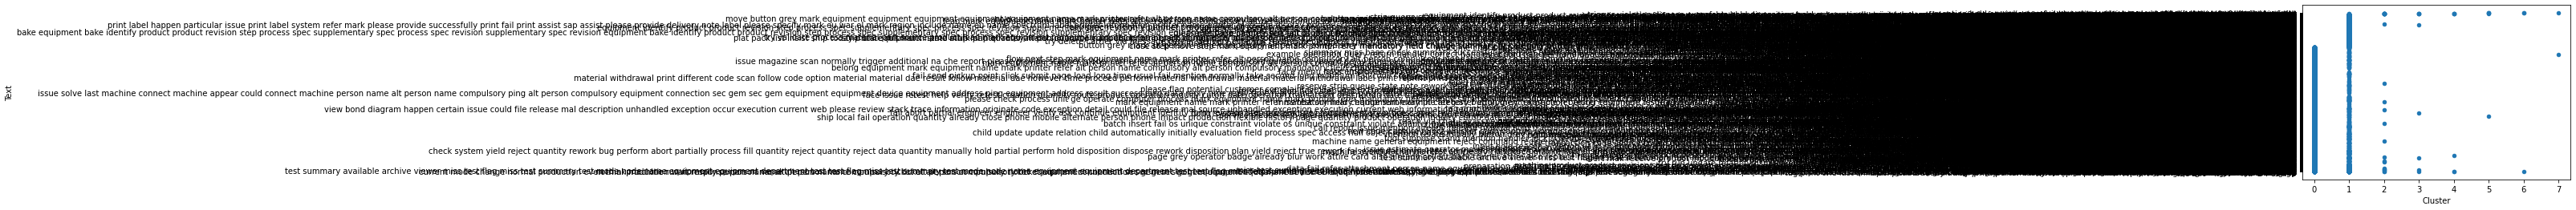

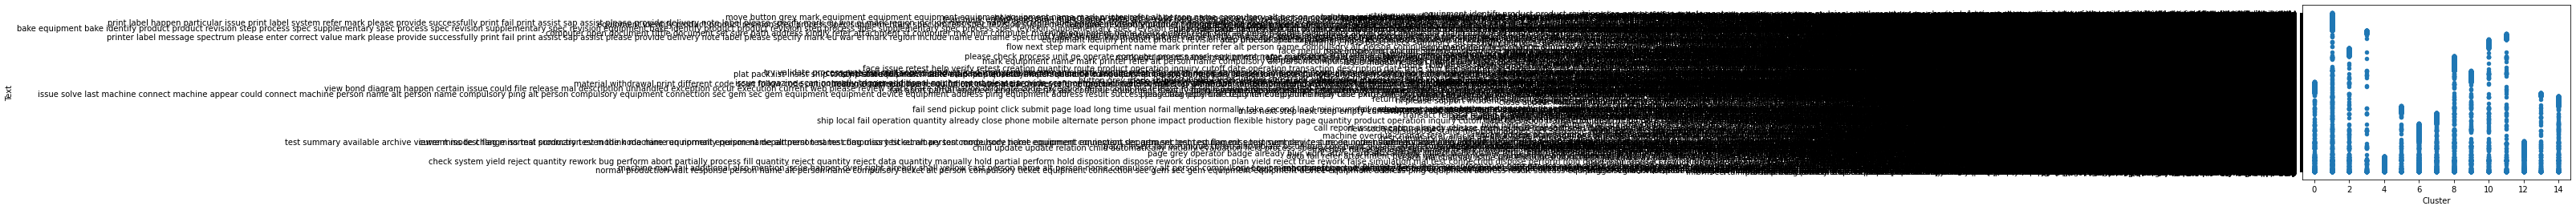

In [8]:
print(f'DataFrame from neighborhood detection:\n {neighborhood_detection_df}')
print(f'DataFrame from Kmeans detection:\n {kmeans_df}')
cr.plot_cluster(neighborhood_detection_df)
cr.plot_cluster(kmeans_df)

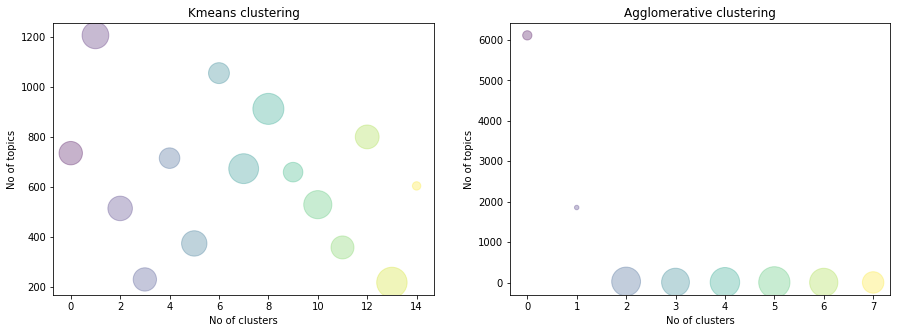

In [9]:
import matplotlib.pyplot as plt
# n_df,k_df=compute_topics('bert-large-uncased')
kg_df=kmeans_df.groupby('Cluster').agg({'Text':'count'}).reset_index()
ng_df=neighborhood_detection_df.groupby('Cluster').agg({'Text':'count'}).reset_index()

#Plotting
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
rng = np.random.RandomState(0)
s=1000*rng.rand(len(kg_df['Text']))
s1=1000*rng.rand(len(ng_df['Text']))
ax1.scatter(kg_df['Cluster'],kg_df['Text'],s=s,c=kg_df['Cluster'],alpha=0.3)
ax1.set_title('Kmeans clustering')
ax1.set_xlabel('No of clusters')
ax1.set_ylabel('No of topics')
ax2.scatter(ng_df['Cluster'],ng_df['Text'],s=s1,c=ng_df['Cluster'],alpha=0.3)
ax2.set_title('Agglomerative clustering')
ax2.set_xlabel('No of clusters')
ax2.set_ylabel('No of topics')
plt.show()

In [10]:
kmeans_df.to_csv("new.csv")

In [11]:
neighborhood_detection_df.to_csv("new1.csv")

In [5]:
df_reviews.desc.replace("quantityity", "quantity", regex=True, inplace = True)

In [32]:
# lookup = "lookup.xlsx"
# typo = pd.read_excel(lookup, sheet_name="typo")
# worddict = dict(zip(typo.words, typo.correction))
df_reviews.desc.replace(worddict, regex=True, inplace=True)

In [ ]:
df_revie

In [42]:
def corr_sent(worddict,sent):
    texts= sent.split(" ")
    for i in texts:
        if i in worddict.keys():
            print(worddict[i])
            sent = sent.replace(i, worddict[i])
    return sent
a=df_reviews.desc.map(lambda x: corr_sent(worddict, x))

equipment
quantity
quantity
quantity
equipment
quantity
quantity
equipment
equipment
color
quantity
quantity
quantity
equipment
equipment
complete
equipment
complete
quantity
equipment
equipment
equipment
equipment
quantity
equipment
equipment
equipment
complete
equipment
quantity
equipment
equipment
equipment
equipment
equipment
equipment
quantity
quantity
equipment
equipment
quantity
equipment
equipment
equipment
quantity
colour
equipment
equipment
equipment
equipment
equipment
quantity
quantity
quantity
quantity
quantity
quantity
quantity
quantity
quantity
equipment
complete
quantity
complete
equipment
equipment
quantity
quantity
equipment
equipment
equipment
equipment
equipment
equipment
equipment
equipment
quantity
equipment
equipment
equipment
complete
equipment
equipment
equipment
equipment
quantity
quantity
equipment
equipment
color
quantity
quantity
quantity
quantity
equipment
complete
equipment
quantity
quantity
colour
equipment
equipment
equipment
quantity
equipment
quantity

In [38]:
import itertools
worddict = {k:v for k,v in zip(typo.words, typo.correction)}

In [5]:
def removespace_lookup(word):
    return word.strip()

In [44]:
a.loc[8699]

'raise ticket inform problem state inprepareareare inform change inqueue'

In [10]:
typo.words = typo.words.map(lambda x: removespace_lookup(x))
typo.correction = typo.correction.map(lambda x: removespace_lookup(x))